In [1]:
from __future__ import print_function, division
import skimage
import pandas
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader # Handle and load data
from torchvision import transforms, utils
from PIL import Image # Display the images in a plot format
import pandas as pd
from torchvision import models
from torchvision.models import resnet101 # Import the pre-trained resnet101 model
import warnings
warnings.filterwarnings("ignore")
import torch.nn.functional as F
import argparse
import torchvision
import torchvision.transforms as transforms # Perform image augmentation
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from cnn_finetune import make_model # tools for fine-tuning pre-trained CNNs

/mnt/beegfs/home/aismail2021/.local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the parameters of the model

parser = argparse.ArgumentParser(description='cnn_finetune')
parser.add_argument('-f')
parser.add_argument('--batch-size', type=int, default=8, metavar='N',
                    help='input batch size for training (default: 8)')
parser.add_argument('--epochs', type=int, default=500, metavar='N',
                    help='number of epochs to train (default: 500)')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001)')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum (default: 0.9)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--model-name', type=str, default='resnet101', metavar='M',
                    help='model name (default: resnet101)')

args = parser.parse_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Allows for usage of GPU

In [3]:
class FloodTinyDataset(Dataset):

    def __init__(self, df, transform = None):
       
        self.flood_tiny_data = df
        ''' Change self.root_dir to load images '''
        self.root_dir = f"/mnt/beegfs/home/aismail2021/LADI/beegfs/home/LADI-DATASET/Images/flood_tiny/"
        self.transform = transform

    def __len__(self):
        return len(self.flood_tiny_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        pos = self.flood_tiny_data.iloc[idx, 9].rfind('/')+1
        img_name = os.path.join(self.root_dir, self.flood_tiny_data.iloc[idx, 9][pos:])  
        
        image = Image.fromarray(io.imread(img_name))
        uuid = self.flood_tiny_data.iloc[idx, 1]
        timestamp = self.flood_tiny_data.iloc[idx, 2]
        gps_lat = self.flood_tiny_data.iloc[idx, 3]
        gps_lon = self.flood_tiny_data.iloc[idx, 4]
        gps_alt = self.flood_tiny_data.iloc[idx, 5]
        file_size = self.flood_tiny_data.iloc[idx, 6]
        width = self.flood_tiny_data.iloc[idx, 7]
        height = self.flood_tiny_data.iloc[idx, 8]
        ### Labels should be numerical, not bool for training ###
        if self.flood_tiny_data.iloc[idx, -1] == True:
            label = 1 # Flood
        else:
            label = 0 # Non-Flood
        
        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'image_name': img_name, 'label': label, 'uuid': uuid, 'timestamp': timestamp, 'gps_lat': gps_lat, 'gps_lon': gps_lon, 'gps_alt': gps_alt, 'orig_file_size': file_size, 'orig_width': width, 'orig_height': height}

        return sample

In [4]:
csv_file = '/mnt/beegfs/home/aismail2021/LADI/beegfs/home/LADI-DATASET/Images/flood_tiny/flood_tiny_metadata.csv'
label_csv = '/mnt/beegfs/home/aismail2021/LADI/beegfs/home/LADI-DATASET/Images/flood_tiny/flood_tiny_label.csv'

metadata = pd.read_csv(csv_file)
label = pd.read_csv(label_csv)
all_data = pd.merge(metadata, label, on="s3_path")

class_zero = all_data[all_data['label'] == False]
class_one = all_data[all_data['label'] == True]

sample_size = 1250

if len(class_zero) < sample_size:
    sample_size = len(class_zero)

if len(class_one) < sample_size:
    sample_size = len(class_one)

class_zero = class_zero.sample(n=sample_size)
class_one = class_one.sample(n=sample_size)

flood_tiny_data = pd.concat([class_zero, class_one]).sample(frac=1).reset_index(drop=True)

flood_tiny_dataset = FloodTinyDataset(df=flood_tiny_data)

In [5]:
transformed_dataset = FloodTinyDataset(df=flood_tiny_data, transform=transforms.Compose([
transforms.Resize(256),
transforms.RandomRotation(10),
transforms.RandomCrop(250),
transforms.RandomHorizontalFlip(), 
transforms.ToTensor()]))

Before Transformations


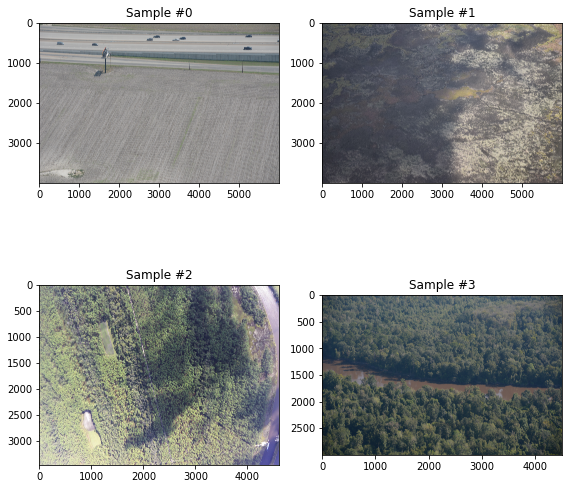

In [6]:
import random

random_images_list = []

fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # Create a 2x2 grid of subplots

# Randomly sample 4 indices from the range of available images
random_indices = random.sample(range(len(flood_tiny_dataset)), 4)

for i, idx in enumerate(random_indices):
    sample = flood_tiny_dataset[idx]

    # Calculate the subplot indices
    row = i // 2
    col = i % 2

    axes[row, col].imshow(sample['image'])
    axes[row, col].set_title('Sample #{}'.format(i))

    random_images_list.append(sample['image'])
    
    if i == 3:
        break

print('Before Transformations')            
plt.tight_layout()
plt.show()

In [7]:
# Apply the specified transformations to each image in random_images_list
transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(10),
    transforms.RandomCrop(250),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

After Transformations


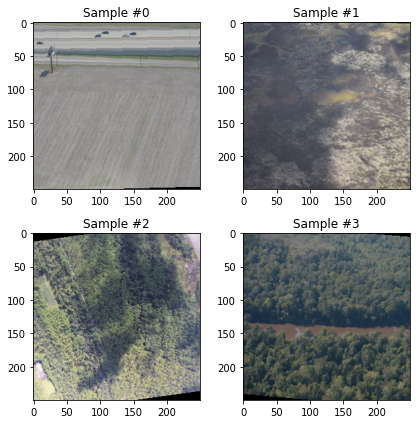

In [8]:
transformed_images_list = []
for image in random_images_list:
    transformed_image = transformations(image)
    transformed_images_list.append(transformed_image)

# Display the transformed images in a new plot
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

for i, image in enumerate(transformed_images_list):
    row = i // 2
    col = i % 2
    
    # Convert from tensor format (C x H x W) to (H x W x C) for displaying
    image = image.permute(1, 2, 0)
    axes[row, col].imshow(image)
    axes[row, col].set_title('Sample #{}'.format(i))

print('After Transformations')    
plt.tight_layout()
plt.show()

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

batch_size=args.batch_size
test_split_ratio = .2 # 20% of data used for testing, 80% for training
shuffle_dataset = True
random_seed= 42
# Creating data indices for training and validation splits:
dataset_size = len(transformed_dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split_ratio * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size, sampler=test_sampler)

In [10]:
def train(model, epoch, optimizer, train_loader, criterion=nn.CrossEntropyLoss()):
    running_loss = 0
    total_size = 0
    model.train()

    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs = data['image']
        labels = data['label']
        inputs = inputs.to(device)
        labels = labels.to(device)
        # casting int to long for loss calculation#
        labels = labels.long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        total_size += inputs.size(0)
        loss.backward()
        optimizer.step()

        if i % 20 == 19:   
            print('[%d, %3d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
    
print('Finished Training')

Finished Training


In [ ]:
def test(model, test_loader, criterion=nn.CrossEntropyLoss()):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs = data['image']
            labels = data['label']
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            #test_loss += criterion(output, target).item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            #correct += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    accuracy = 100 * correct / total
    print('Accuracy of the network on the 400 test images: %d %%' % (
    accuracy))

    state = {'epoch': epoch, 'state_dict': model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict()}

    model_name = 'resnet101_%d_%d.pth' % (epoch, accuracy)
    PATH = f"/mnt/beegfs/home/aismail2021/{model_name}"
    torch.save(state, PATH)

model_name = args.model_name

# classes = ('0','1') 
model = make_model(
        model_name,
        pretrained=True,
        num_classes=2,
        input_size= None,
    )
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum= args.momentum)

model_name = 'resnet101_18_80.pth'
PATH = f"/mnt/beegfs/home/aismail2021/Ladi_Training/ResNet/2/2_resnet101_18_80.pth" 
checkpoint = torch.load(PATH)
start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#gamma: Multiplicative factor of learning rate decay.
#Step_size: Period of learning rate decay.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
for epoch in range(0, args.epochs):
  scheduler.step(epoch)
  train(model, epoch, optimizer, train_loader)
  test(model, test_loader)

[1,  20] loss: 0.471
[1,  40] loss: 0.671


In [11]:
PATH = '/mnt/beegfs/groups/ladi-dataset/Best_Model/5_resnet101_109_82.40.pth'

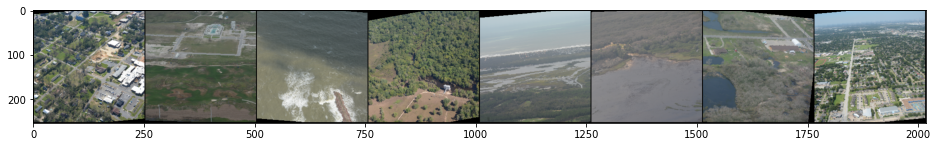

GroundTruth:  tensor(0) tensor(1) tensor(1) tensor(0) tensor(1) tensor(1) tensor(0) tensor(0)
Predicted:    tensor(0) tensor(1) tensor(1) tensor(0) tensor(1) tensor(1) tensor(0) tensor(0)


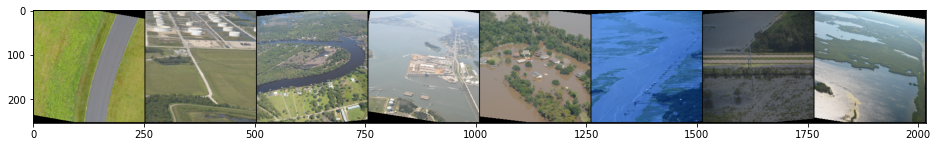

GroundTruth:  tensor(0) tensor(0) tensor(1) tensor(1) tensor(1) tensor(1) tensor(1) tensor(1)
Predicted:    tensor(0) tensor(0) tensor(1) tensor(0) tensor(1) tensor(1) tensor(0) tensor(1)


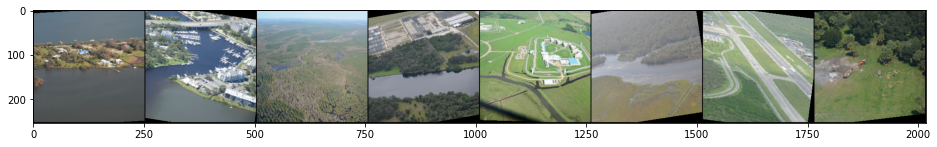

GroundTruth:  tensor(1) tensor(0) tensor(1) tensor(0) tensor(1) tensor(1) tensor(0) tensor(0)
Predicted:    tensor(1) tensor(0) tensor(1) tensor(0) tensor(1) tensor(1) tensor(0) tensor(0)


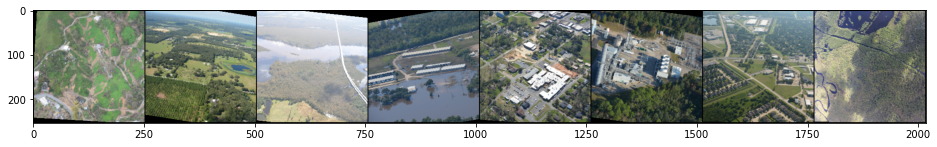

GroundTruth:  tensor(0) tensor(0) tensor(1) tensor(1) tensor(0) tensor(1) tensor(1) tensor(1)
Predicted:    tensor(0) tensor(0) tensor(1) tensor(1) tensor(0) tensor(1) tensor(1) tensor(1)


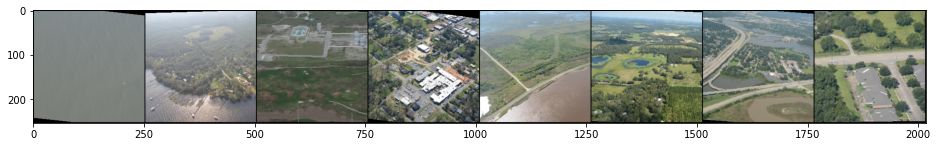

GroundTruth:  tensor(0) tensor(1) tensor(1) tensor(0) tensor(1) tensor(0) tensor(1) tensor(0)
Predicted:    tensor(0) tensor(1) tensor(1) tensor(0) tensor(1) tensor(0) tensor(1) tensor(0)


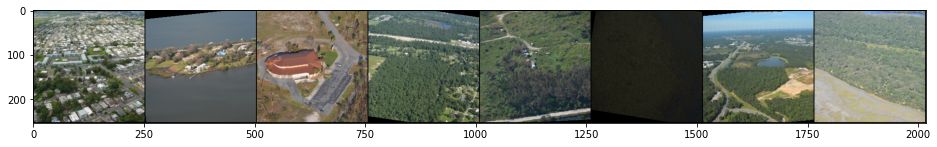

GroundTruth:  tensor(0) tensor(1) tensor(0) tensor(0) tensor(0) tensor(1) tensor(1) tensor(0)
Predicted:    tensor(0) tensor(1) tensor(0) tensor(0) tensor(0) tensor(1) tensor(1) tensor(0)


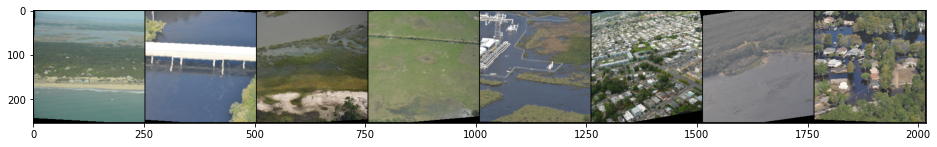

GroundTruth:  tensor(1) tensor(1) tensor(1) tensor(1) tensor(1) tensor(0) tensor(1) tensor(1)
Predicted:    tensor(0) tensor(1) tensor(1) tensor(1) tensor(1) tensor(0) tensor(0) tensor(1)


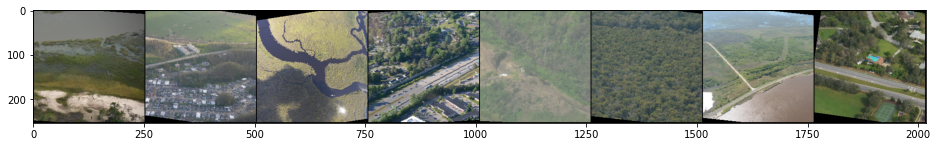

GroundTruth:  tensor(1) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(1) tensor(0)
Predicted:    tensor(1) tensor(1) tensor(0) tensor(0) tensor(0) tensor(0) tensor(1) tensor(0)


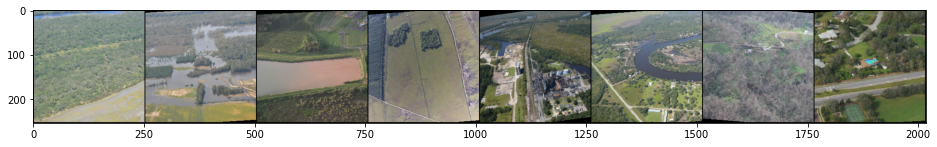

GroundTruth:  tensor(0) tensor(1) tensor(0) tensor(1) tensor(1) tensor(1) tensor(0) tensor(0)
Predicted:    tensor(0) tensor(1) tensor(0) tensor(1) tensor(1) tensor(1) tensor(0) tensor(0)


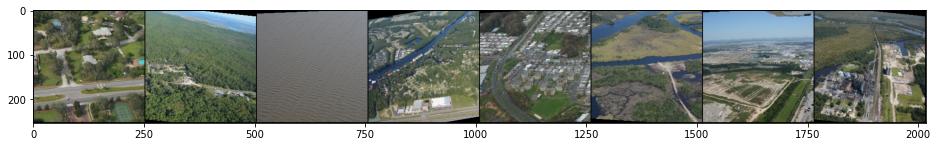

GroundTruth:  tensor(0) tensor(0) tensor(0) tensor(1) tensor(1) tensor(1) tensor(1) tensor(1)
Predicted:    tensor(0) tensor(0) tensor(0) tensor(1) tensor(1) tensor(1) tensor(1) tensor(1)


In [12]:
for _ in range(10):  
    checkpoint = torch.load(PATH)
    
    def imshow(img):
        npimg = img.numpy()
        plt.figure(figsize=[16, 16])
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    dataiter = iter(test_loader)
    batch = next(dataiter)
    images = batch['image']
    labels = batch['label']

    # print images
    classes = (0, 1)
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(8)))

    checkpoint = torch.load(PATH)

    model_name = args.model_name
    # classes = ('0','1') 
    model = make_model(
            model_name,
            pretrained=True,
            num_classes=2,
            input_size= None,
        )

    model.load_state_dict(checkpoint['state_dict'])

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum= args.momentum)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted:   ', ' '.join('%5s' % predicted[j]
                                  for j in range(8)))